In [1]:
import matplotlib.pyplot as plt

In [2]:
# Fetch data
!wget -O M2EA05-01-bin4-s200-zeroed.tif -q 'https://zenodo.org/record/7137640/files/M2EA05-01-bin4-s200-zeroed.tif?download=1'

# 3D imaging of opaque materials with tomography

Edward Andò (EPFL Center for Imaging)

As justified in the introduction to this section, in the case of experimental geomechanics,
a non-destructive 3D picture of a sample being tested -- especially one at the pertinent internal
scales (of the most important inclusions, pores, particles) can reveal a lot about the structure of the material.

Furthermore, leveraging the non-destructiveness of x-ray tomography, multiple different states can be imaged
resulting in a time-series of 3D images, sometimes known as a 3D+t or 4D dataset (time being one of the dimensions).

Unlike the case of RIMS described above, in an opaque (to visible light) material, it is not possible to directly illuminate and image a 2D slice within the material, thus obtaining the 3D image by correcting and stitching the acquired images.
The "trick" to making a 3D image is to make an image using something other than visible light, typically higher-energy light (in the form of x-rays or gamma rays) but Neutrons can also work.
X-rays photons are higher energy than visible light photons and (also) have quite complex interaction with matter.
What is leveraged for volumetric imaging is the fact that relatively high-energy x-rays are not easily stopped by matter -- the intensity of light (in photons/second) can be reduced ("attenuated") but some x-ray light will shine through centrimetric-sized objects with minimum deviation.


## From Beer-Lambert Law to Radiograph

The law that dictates how x-ray intensity varies with the thickness of the object being traversed is the famous Beer-Lambert Law.
The initial x-ray intensity $I_0$ is reduced to an "output" intensity $I$ (expected to be $\le I_0$):

$I = I_0^{-\mu x}$

...where $x$ is the path length and $\mu$ is an attenuation coefficient (which in this case hides a lot of complexity, notably a dependnence on density, but also on x-ray energy).
Looking at the equation, when the path length is zero then $I = I_0$, and for fixed $\mu$, as $x$ increases, $I$ reduces explonentially.

The attenuation coefficient for x-rays tends to follow the atomic number and therefore roughtly the density of the material.
In the appendix of [Grünauer, F. (2005). Design, optimization, and implementation of the new neutron radiography facility at FRM-II (Doctoral dissertation, Technische Universität München)] an extremely convenient periodic table is found showing the difference between neutron and x-ray attenuation (for a fixed energy) -- note the progressive increase of x-ray attenuation from top to bottom.

<img width="600" alt="Coude fp" src="https://next-grenoble.fr/static/home/images/XN.jpg"></a>

In the case of x-ray imaging, we now know that we will be interested in x-rays that travel straight through the specimen,
and that denser materials will attenuate more x-rays.
The figure below shows a very simple system that allows a 1D x-ray image of an object to be acquired.
A parallel x-ray beam is generated on the left, the beam travels through the object (and is partially attenuated).
The attenuated beam is then measured on a detector on the right.
Normally the procedure is to measure the x-ray intensity without the object in place ($I_0$, also known as a "flat-field") and 
compare it to the x-ray intensity measured with the object in place ($I$).

<img width="600" src="https://zenodo.org/record/7137640/files/parallel_2D.png?download=1"></a>

What is measured using the detector is the x-ray *transmission* through the object, 
it goes without saying that x-rays absolrbed by the object are not detected.
If the detector is composed of a series of individiual pixels (a so-called "line detector"), the resulting measurement is a vector of numerical values representing x-ray intensity.
Although a lot of line detector are used in industry (but also research), the most common form of x-ray detector for imaging is a flat-panel detector, meaning that what is measured is a 2D matrix of values:

<img width="600" alt="Coude fp" src="https://zenodo.org/record/7137640/files/parallel_3D.png?download=1"></a>

Such a 2D image representing the attenuation of the sample is called a radiograph.
Since bones attenuate significantly more that the surrounding flesh, this is a key tool for the medical investigation of broken bones, as illustrated below.

<a title="MB, CC BY-SA 2.5 &lt;https://creativecommons.org/licenses/by-sa/2.5&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Coude_fp.PNG"><img width="400" alt="Coude fp" src="https://upload.wikimedia.org/wikipedia/commons/9/93/Coude_fp.PNG"></a>

N.B. in the particular case of medical imaging, dark values represent high transmission.
Taking this into account, one can see that the bone indeed attenuates much more than the surrounding flesh, and some internal structures are visible.

## Radiograph to Projection to Reconstruction

Such a radiograph allows a number of things to be understood -- it is a view *through* an object.
Indeed this was used to great effect in Roscoe's 1970 work <cite data-cite="roscoe1970influence">(Roscoe, 1970)</cite> to track lead shot (highly attenuating) deep within a geotechnical experiment.

However this imaging modality is highly dependent on the orientation of the object being scanned.
With the explicit aim of building up a 3D picture of the object, it is useful to think about a radiograph as an image resulting from *the summing of the attenuation along each beam path*.
Said differently, the radiograph is a flattened picture of the object *projected* in the direction of the beam.
In the context of "reconstructing" a 3D picture of the object a radiograph is often referred to as a *projection*.

The objective thus is to try to make an unflattened picture of the object: the trick here will be to measure projections at different angles and try to compute the 3D object that could have created these projections: this is *par excellence* an inverse problem.
The function that we're trying to onverse is the **Radon transform**.

For the sake of illustration, we will use the following parallel, 2D imaging geometry (discussed above):

<img width="600" src="https://zenodo.org/record/7137640/files/parallel_2D.png?download=1"></a>

In this case therefore, the obejctive will simply to "reconstruct" the 2D slice of the object -- if this is successful, the process can be repeated for all other horizontal rows on the detector.

The rest of the notebook is based on the radon transform notebook from scikit-image:
[<cite data-cite="van2014scikit">(Van der Walt et al., 2014)</cite>
https://scikit-image.org/docs/stable/auto_examples/transform/plot_radon_transform.html

## Computing a single projection at a given angle

We will start from the slice we're trying to measure as a basis, this is taking from previously reconstructed data -- it's a 2D slice through a cylinder containing grains.
The first step will be to simulate a projection of this field in a single direction -- this is the only thing that we're able to measure.
Feel free to vandalise the loaded image with some veyr high pixel to see where they end up in two two projections at 0 and 90°.
What we are doing here is a "forward projection" of the known 2D field into a 1D signal.

Loaded image dimensions: (250, 250)


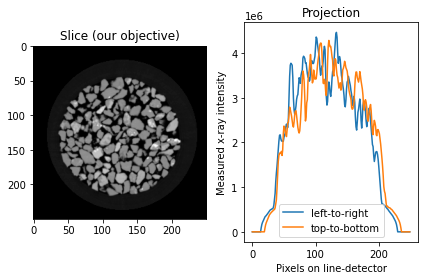

In [3]:
import numpy
import tifffile
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

image = tifffile.imread("./M2EA05-01-bin4-s200-zeroed.tif").astype(float)
print(f"Loaded image dimensions: {image.shape}")
#image[10:15, 100:115] = 400000

plt.subplot(1, 2, 1)
plt.title("Slice (our objective)")
plt.imshow(image, cmap=plt.cm.Greys_r)

plt.subplot(1, 2, 2)
plt.title("Projection")
#print(radon(image, theta=numpy.array([90])))
      
plt.plot(radon(image, theta=numpy.array([90])), label='left-to-right')
plt.plot(radon(image, theta=numpy.array([0])), label='top-to-bottom')
plt.ylabel("Measured x-ray intensity")
plt.xlabel("Pixels on line-detector")
plt.legend()

plt.tight_layout()
plt.show()

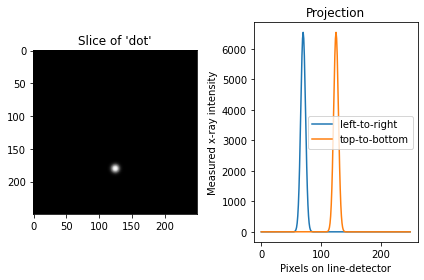

In [4]:
import scipy.ndimage

imageDot = numpy.zeros_like(image)
imageDot[180, 125] = 65535
imageDot = scipy.ndimage.gaussian_filter(imageDot, 4)

plt.subplot(1, 2, 1)
plt.title("Slice of 'dot'")
plt.imshow(imageDot, cmap=plt.cm.Greys_r)

plt.subplot(1, 2, 2)
plt.title("Projection")
#print(radon(image, theta=numpy.array([90])))
      
plt.plot(radon(imageDot, theta=numpy.array([90])), label='left-to-right')
plt.plot(radon(imageDot, theta=numpy.array([0])), label='top-to-bottom')
plt.ylabel("Measured x-ray intensity")
plt.xlabel("Pixels on line-detector")
plt.legend()

plt.tight_layout()
plt.show()

## Computing a sinogram

The two different projections above might be sufficient to get an idea of a very simple object such as a square aligned with the image,
but in the general two views are not sufficient.
What needs to be acquired is a large number of different projections -- in the case of filtered back projection, the Nyquist-Shannon sampling theorem gives us:

$P \geq \frac{\pi}{2}S$ -- with P being the number of Projections and S roughtly the number of pixels along one side of the reconstructed slice. <cite data-cite="kharfi2013mathematics">(Kharfi, 2013)</cite>

Let's try to "acquire" this many different projection angles on our fake data above, as it rotates around 360°.
The slice is 250x250 pixels meaning P should be more than 392, let's call it 400 different angles.
Instead of producing 392 different 1D plots as above, we will define a new way to look at the data, a **sinogram**.

As seen above our simulated linear detector has 250 pixels, so we will define a new "image" of size 250 (pixels) by 400 different angles;
this is a sinogram (the reason will become apparent in a second), and is the default input to a reconstruction algorithm.
For every projection angle (like the two simulated above), the resulting 250 "measurements" will be written into one line of the sinogram.

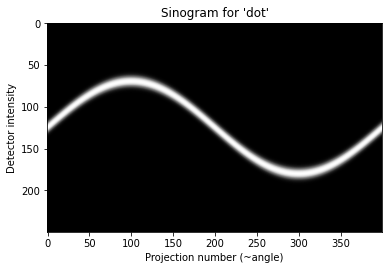

In [5]:
theta = numpy.linspace(0., 360., 400, endpoint=False)
sinogramDot = radon(imageDot, theta=theta)

plt.imshow(sinogramDot, cmap="Greys_r")
plt.title("Sinogram for 'dot'")
plt.ylabel("Detector intensity")
plt.xlabel("Projection number (~angle)")
plt.show()

The dot of `imageDot` clearly describes a sinusoid.
In the case of a parallel beam, there is only need to spread the angles to acquire through 180° instead of 360°, 
but this is not the general case with a divergent (cone, or in 2D, fan) beam.

Play around with `imageDot` (add more dots, perhaps one in the centre) and see the effect in the sinogram.
You'll see that the further an object is from the center of rotation, the larger the ampitude of the sine wave.

Going back to the much more complex grains data, here is the corresponding sinogram:

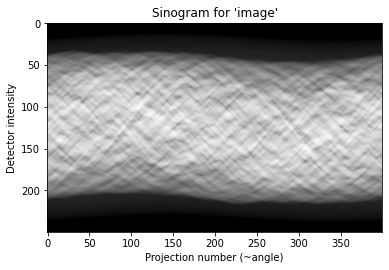

In [6]:
theta = numpy.linspace(0., 360., 400, endpoint=False)
sinogram = radon(image, theta=theta)

plt.imshow(sinogram, cmap="Greys_r")
plt.title("Sinogram for 'image'")
plt.ylabel("Detector intensity")
plt.xlabel("Projection number (~angle)")
plt.show()

## Reconstruction with the Filtered Back Projection (FBP)

The mathematical foundation of the filtered back projection is the Fourier
slice theorem. It uses Fourier transform of the projection and
interpolation in Fourier space to obtain the 2D Fourier transform of the
image, which is then inverted to form the reconstructed image. The filtered
back projection is among the fastest methods of performing the inverse
Radon transform. The only tunable parameter for the FBP is the filter,
which is applied to the Fourier transformed projections. It may be used to
suppress high frequency noise in the reconstruction. ``skimage`` provides
the filters 'ramp', 'shepp-logan', 'cosine', 'hamming', and 'hann':



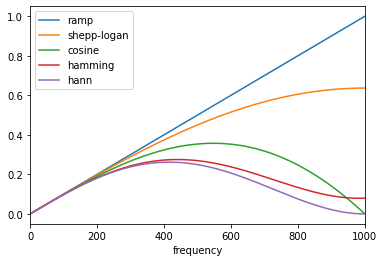

In [7]:
import matplotlib.pyplot as plt
from skimage.transform.radon_transform import _get_fourier_filter

filters = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']

for ix, f in enumerate(filters):
    response = _get_fourier_filter(2000, f)
    plt.plot(response, label=f)

plt.xlim([0, 1000])
plt.xlabel('frequency')
plt.legend()
plt.show()

Applying the inverse radon transformation with the 'ramp' filter, we get:



FBP rms reconstruction error: 1.06e+03


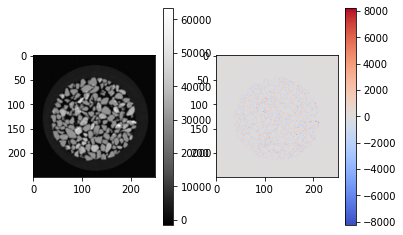

In [8]:
from skimage.transform import iradon

reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='ramp')
error = reconstruction_fbp - image
print(f'FBP rms reconstruction error: {numpy.sqrt(numpy.mean(error**2)):.3g}')

maxError = numpy.max(numpy.abs(error))
imkwargs = dict(vmin=-maxError, vmax=maxError)

plt.subplot(1,2,1)
plt.imshow(reconstruction_fbp, cmap='Greys_r')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(error, cmap='coolwarm', **imkwargs)
plt.colorbar()

plt.show()

## Reconstruction with the Simultaneous Algebraic Reconstruction Technique

Algebraic reconstruction techniques for tomography are based on a
straightforward idea: for a pixelated image the value of a single ray in a
particular projection is simply a sum of all the pixels the ray passes
through on its way through the object. This is a way of expressing the
forward Radon transform. The inverse Radon transform can then be formulated
as a (large) set of linear equations. As each ray passes through a small
fraction of the pixels in the image, this set of equations is sparse,
allowing iterative solvers for sparse linear systems to tackle the system
of equations. One iterative method has been particularly popular, namely
Kaczmarz' method, which has the property that the solution will
approach a least-squares solution of the equation set.

The combination of the formulation of the reconstruction problem as a set
of linear equations and an iterative solver makes algebraic techniques
relatively flexible, hence some forms of prior knowledge can be
incorporated with relative ease.

``skimage`` provides one of the more popular variations of the algebraic
reconstruction techniques: the Simultaneous Algebraic Reconstruction
Technique (SART). It uses Kaczmarz' method as the iterative
solver. A good reconstruction is normally obtained in a single iteration,
making the method computationally effective. Running one or more extra
iterations will normally improve the reconstruction of sharp, high
frequency features and reduce the mean squared error at the expense of
increased high frequency noise (the user will need to decide on what number
of iterations is best suited to the problem at hand. The implementation in
``skimage`` allows prior information of the form of a lower and upper
threshold on the reconstructed values to be supplied to the reconstruction.



SART (1 iteration) rms reconstruction error: 1.48e+03
SART (2 iterations) rms reconstruction error: 823


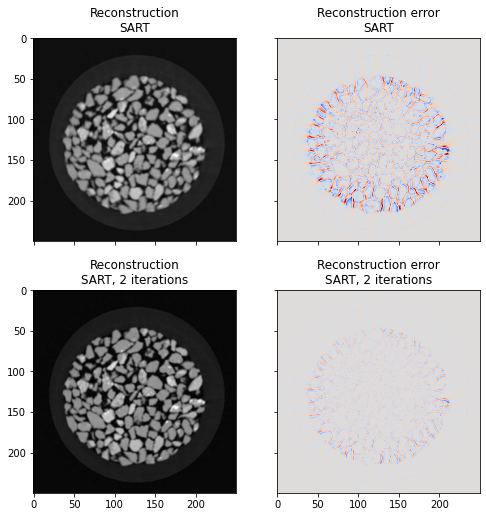

In [9]:
from skimage.transform import iradon_sart

reconstruction_sart = iradon_sart(sinogram, theta=theta)
error = reconstruction_sart - image
print(f'SART (1 iteration) rms reconstruction error: '
      f'{numpy.sqrt(numpy.mean(error**2)):.3g}')

fig, axes = plt.subplots(2, 2, figsize=(8, 8.5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].set_title("Reconstruction\nSART")
ax[0].imshow(reconstruction_sart, cmap=plt.cm.Greys_r)

ax[1].set_title("Reconstruction error\nSART")
ax[1].imshow(reconstruction_sart - image, cmap=plt.cm.coolwarm, **imkwargs)

# Run a second iteration of SART by supplying the reconstruction
# from the first iteration as an initial estimate
reconstruction_sart2 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart)
error = reconstruction_sart2 - image
print(f'SART (2 iterations) rms reconstruction error: '
      f'{numpy.sqrt(numpy.mean(error**2)):.3g}')

ax[2].set_title("Reconstruction\nSART, 2 iterations")
ax[2].imshow(reconstruction_sart2, cmap=plt.cm.Greys_r)

ax[3].set_title("Reconstruction error\nSART, 2 iterations")
ax[3].imshow(reconstruction_sart2 - image, cmap=plt.cm.coolwarm, **imkwargs)
plt.show()


Returning back to 3D with a parallel beam (as pictured below) the line detector example developed above now corresponds to a horizontal row of pixels on the detector.
Each row can be reconstructed separately, and thus a series of horizontal cross-sections can be recovered.
Stacking them all together will yield a 3D image with slices as thick as the pixel size (in this case the pixel size of the detector if there's no magnification).

<img width="600" src="https://zenodo.org/record/7137640/files/parallel_3D.png?download=1"></a>

In a lab x-ray scanner, a different type of x-ray source is used, which emits a divergent x-ray beam from a small point (by focussing an electron beam onto a target which generates x-rays).

In the same vein as the higher up sketch above, the imaging system now looks like this:

<img width="600" src="https://zenodo.org/record/7137640/files/divergent_2D.png?download=1"></a>

In 2D this is known as a fan-beam, and although the mathematical function represents the projection is a little more complex (and outside the scope of this tutorial), however it is hoped that it's possible to imagine that with some geometry it is possible to integrate along each beam path between pixel on the detector and the source.
In this case the pixel size is not given by the phiscal size of pixels on the detector but rather the geometry of the imaging.
The edges of a pixel and the source spot make a triangle, that describes the decreasing pixel size as a sample is translated closer to the source.

The same argument as above applies to the passage to 3D scanning with a flat-panel:

<img width="600" src="https://zenodo.org/record/7137640/files/divergent_3D.png?download=1"></a>

The "Feldkamp" algorithm can be used to reconstruct 3D divergent "cone beam" projections in 3D.

## Quantitative use of the reconstructed field

The reconstructed field is basically $\mu(x, y, z)$.
However unless a *monochromatic* (*i.e.*, with only one energy) x-ray beam is used, or a *spectral* detector (which detects the energy of incoming photons, exceedlingly rare as of time of writing), the dependency of $\mu$ on x-ray energy cannot be made, meaning that the reconstructed value is often called a "CT value" rather than a quantitative $\mu$.

Polychromatic x-ray sources being detected with simple detectors (the overwhelmingly most common cause) can have some problems due to the fact that energy cannot be studied, such as an artefact called *beam hardening*.

Experience shows that between repeated scans in the same imaging configuration, the CT value can drift a little: this can normally be corrected by having some reference materials in the picture which can be used to normalise CT values with time.

However once this essential step is made, the evolution of CT values can be expected to follow the mass transfer in the system.
It is on this basis that optical flow equations (conservation of CT values) can be written, enabling particle tracking that will be the object of the next tutorial.

Going further, a recent paper <cite data-cite="stavropoulou2020dynamics">(Stavropuolou et al, 2020)</cite> uses this fact to predict evolution of CT values during swelling.